<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Web-Scrap" data-toc-modified-id="Web-Scrap-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Web Scrap</a></span></li><li><span><a href="#Pre-processing" data-toc-modified-id="Pre-processing-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Pre-processing</a></span></li><li><span><a href="#OCR" data-toc-modified-id="OCR-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>OCR</a></span></li><li><span><a href="#Create-dictionnary" data-toc-modified-id="Create-dictionnary-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Create dictionnary</a></span></li><li><span><a href="#Comparison-of-Traduction-(processed-and-not-processed)" data-toc-modified-id="Comparison-of-Traduction-(processed-and-not-processed)-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Comparison of Traduction (processed and not processed)</a></span></li><li><span><a href="#Correct-Realignment-of-Texts" data-toc-modified-id="Correct-Realignment-of-Texts-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Correct Realignment of Texts</a></span></li><li><span><a href="#Result" data-toc-modified-id="Result-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Result</a></span></li><li><span><a href="#Remarks" data-toc-modified-id="Remarks-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Remarks</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re
import time
from datetime import datetime
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from PIL import Image
from urllib.request import urlopen
from bs4 import BeautifulSoup
import json
from skimage import data,filters
import scipy.ndimage
import cv2
import urllib.request
import enchant
import regex as re
import collections

### Web Scrap

In [2]:
def retrieve_url_and_title(url):
    """
    Retrieve image and title of Rolandi page of sub collection.
    Arguments: url (url to image we want to process)
    """
    # The page where the image is
    page_html = urlopen(url)
    soup = BeautifulSoup(page_html, 'html')
    
    # Find all external links
    # The link for the json of the image always starts with 'http://dl.cini.it/oa/items/'
    pages = [i.text for i in soup.find_all('a') if 'http://dl.cini.it/oa/items/' in str(i)]
    json_url = pages[0]
    
    # We find the url of the image in the json
    json_html = urlopen(json_url)
    
    # Loading the json
    soup = BeautifulSoup(json_html, 'html')
    json_file = json.loads(soup.text)
    
    # Finding the url of the image and its title
    title = json_file['label']
    url_image = json_file['sequences'][0]['canvases'][0]['images'][0]['resource']['@id']

    
    return title, url_image

### Pre-processing 

In [3]:
def pre_processing(path='temporary.jpg', output_path='processed.jpeg'):
    """
    Processes image to remove noisy background.
    Arguments: path (path to local saved image)
               output_path (path where to store the processed image)
    """
    im_0 = cv2.imread(path)
    k_size = 3
    kernel = np.ones((k_size, k_size), np.uint8)
    im_dilated = cv2.dilate(im_0, kernel, iterations=2)
    im_eroded = cv2.erode(im_dilated, kernel, iterations=2)
    im_blurred = cv2.GaussianBlur(im_eroded, (0, 0), 3)
    im_better = cv2.addWeighted(im_0, 0.55, im_blurred, 0.6, 0)
    
    plt.figure(figsize=(20,10))
    plt.imshow(im_better)
    plt.show()

    im = Image.fromarray(im_better)
    im.save(output_path)

### OCR

In [4]:
def detect_text(path):
    """
    Detects text in the file.
    Arguments: path (path to local saved image)
    """
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient.from_service_account_json('C:/Users/gonxh/Documents/EPFL/Master/MA3/Foundations of DH/DH - Rolandi Libretti-a52be57f8f03.json')

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
    
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    
    text_result = ""
    bounds = dict()
    
    #Traiter le texte pour qu'il s'append
    for text in texts:
        text_result += " " + text.description
        #Inital formating of dictionary of top left vertices forming the box
        bound = [text.bounding_poly.vertices[0].x, text.description]
        if text.description in bounds:
            bounds[text.bounding_poly.vertices[0].y].append(bound)
        else:
            bounds[text.bounding_poly.vertices[0].y] = [bound]            

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))
    return text_result, bounds

### Create dictionnary

- Utiliser comme key le titre de l'oeuvre
- créer un dictionnaire avec comme key le titre de l'oeuvre et append chaque texte ensemble
- s'assurer que la key existe sinon créer une value vide (liste)
- reformat le texte lu par google vision

### Comparison of Traduction (processed and not processed)

In [7]:
def check_translation(text, name):
    """
    Checks how much words were correctly translated from the italian to english using DeepL tool.
    Arguments: text (translated english text)
               name (string name for output)
    """
    #Remove words containing digits
    text2 = re.sub(r'\w*\d\w*', '', text).strip()
    #List of words
    words = text2.split()
    total_english_words = 0
    total_words = float(len(words))
    
    #Check if translated word is an english dictionnary
    for word in words:
        d = enchant.Dict("en_US")
        total_english_words += d.check(word)
    
    if total_words > 0:
        percentage = (total_english_words/total_words)*100
        print("Percentage of correct translated words: {:.2f}% for the {} text".format(percentage, name))
    else:
        print("Total words detected is", total_words) 
    

In [10]:
def translate(text):
    """
    Translates italian text to english text using DeepL translator tool.
    Arguments: text (italian text)
    """
    from google.cloud import translate_v2 as translate

    translate_client = translate.Client.from_service_account_json('C:/Users/gonxh/Documents/EPFL/Master/MA3/Foundations of DH/DH - Rolandi Libretti-a52be57f8f03.json')

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, source_language = 'it', target_language='en')["translatedText"]
    
    return result


In [ ]:
#Translation done by hand on DeepL Translator website
translated_processed_text = "HOTTA\n101\nob\nSCENA PRIMA. The scene represents the valley of Kent, bathed by a river, on which a rustic bridge is suspended. Behind the village is the gothic bell tower, which rises between the houses of the village. On the front of the scene you can see the outside of the fortified castle and the Duke with sentries. The sun is near sunset, you can hear the sounds of the Hunters' horns and the bagpipe. Two shepherds some shepherdesses cross the hill leading back the greg-nge, the Hunters passing over the bridge retreat to their abi-turi. - A boat lands at the river banks, and the Fishermen descend from it with their tools. 1 LoK022 17logantg not at all The sun's bright face Already at sea the sun hides its splendor The trace already fades over the waves, darker and more melancholy The ethereal veil is made The first star to shine has already risen into heaven. \Hots lio o o o ooh-sooh-soh, to the humble habit, Comrades, now we return to the used sheepfold The flock we reduce. HUNTERS On the flocks, and for the woods, there's no room to wander in their hiding places the beasts are hidden again. A a loe i The scene represents the valley of Kent, bathed by a river, over which a rustic bridge hangs. Behind it is the village and the gothic bell tower, which rises between the houses of the village. In front of the scene you can see the outside of the fortified Duke's castle with sentries. The sun is near sunset, you can hear the sounds of the Hunters' horns and the bagpipe. Two shepherds and some shepherdesses cross the hill, leading back to the greg- ge; the Hunters, passing over the bridge, retire to their friends. - A boat lands at the river banks, and the Fishermen descend from it with their tools. 1 lo ok 022 17 logantg non h9 ib ont MATM La Ja bright face Already in the sea the sun hides; Of its splendor the track Fades already on the waves, More gloomy and melancholic The ethereal veil is made: The first star to shine It has already risen in heaven. A hots lio o o o Сово holli PASTORELLE To the humble habitation, o Companions, we return : Within the used sheepfold The flock we reduce. To HUNTERS On the flocks, and for the woods It is vain to wander; In their hiding places the beasts are hidden again."
translated_original_text = "HOTTA109 oiinga oiinga loe ileThe scene represents the valley of Kent, bathed by a river, on which a rustic bridge is suspended. On the front of the scene you can see the outside of the fortified castle OTAISJIO (OTAISJIO ib ouafisien) 00nnighnd ilb oflsgiuab A1O2 Moipoo 0MAMAON (new init 0ALO JAYA ORA (now the Duke with sentries). The sun is near sunset, you can hear the sounds of the Hunters' horns, and the bagpipe. Two shepherds some shepherdesses cross the hill, leading back to the greg-growth; the hunters, passing over the bridge, retreat to their abi- A boat approaches the river banks, and the fishermen descend from it with their tools. \Ib I 3nyolYE CONLYYa bright face t o ob islmolU rotsoeg ollsozoten s hotes 9 Pioisioon)\noller& ih ollagiste th lnzenYnCORO in mare il sol nasconde; \the sun is already hiding in the sea; of its splendor, the trace is already fading over the waves, darker and more melancholic: \The first star to shine has already risen into heaven. oigisnrigisnrigisn to the humble habit, no Comrades, now we come back: inside the used sheepfold we reduce the flock. HUNTERS On the flocks, and for the woods, there could be more wandering in the hiding places of the beasts, again they hide themselves. SCENE FIRST. bA ITTUT ig 6 oiinga loe il The scene represents the valley of Kent, bathed by a river, over which a rustic bridge is suspended. Behind it is the village and the gothic bell tower, which rises between the houses of the village. In front of the scene you can see the exterior of the fortified castle emoution onood OTAISJIO wko ib ouafisien) 00 nighnd ill ai ib oflsgiuab A1O 2 Moipoo 0MAMAON ovio init 0ALO JAYA ORA of the Duke with sentries. The sun is near sunset, you can hear the sounds of the Hunters' horns, and the bagpipe. Two shepherds and some shepherdesses cross the hill, leading back to the river; the hunters, passing by the bridge, retire to their abi- A boat lands on the river banks, and the fishermen descend from it with their tools.b18liT odors.a foasoini b sD siga iup.aloig ofteT logtoig li 6 olnluommend 9..loganig non o h obronosd sue turi. Fe Toetosa ib I 3 yol YE CONLY Ja bright face t o onAb islmolU rotsoeg ollsozoten s hotes 9 Pioisioon) oller atlib& ih ollagiste th lnzenY CORO Already at sea the sun is hiding; Of its splendor the trace Fades already on the waves, More dark and melancholic The ethereal veil is made: The first star to shine Has already risen into heaven. dliO olleisn ns 9210 Soh oigisnrig PASTORELLE To the humble habit, no o Compagne, omai tornareamo: Entro l'usato ovile Bqa ig Il gregge riduciamo.r dA CACCIATORI Sui greppi, e per le boschi 2 Csbbe E vano più vagar; Nei brovi lor le beve Di nuovo si occultar. De"

### Correct Realignment of Texts

In [ ]:
def allign_text(bounds):
    """
    Sort bounds first by y coordinates, then by x coordinates.
    Arguments: bounds (dictionnary of coordinates and text words)
    """
    bounds_sorted = {a:sorted(bounds[a], key=lambda k: k[0]) for a in bounds}
    ordered_dict = collections.OrderedDict(sorted(bounds_sorted.items()))
    text = sum(sum(ordered_dict.values(), []),[])
    #Remove x coordinnates
    del text[0::2]
    
    return ' '.join(text)

### Result

Document id: 25547
Percentage of correct translated words: 71.41% for the original text


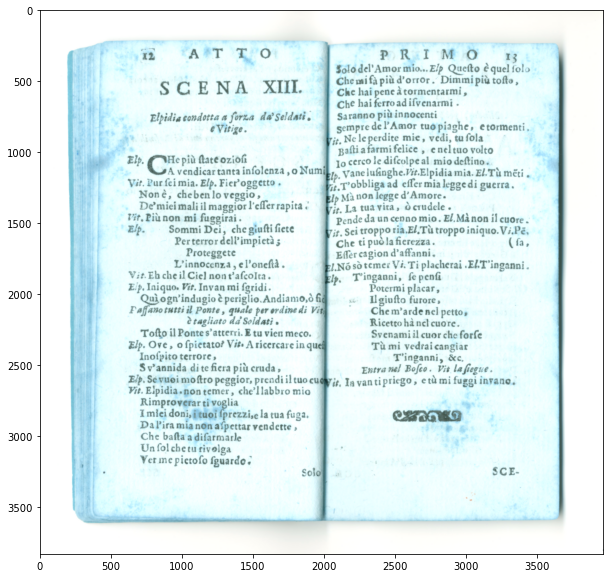

Percentage of correct translated words: 69.06% for the processed text
Document id: 19507
Percentage of correct translated words: 70.09% for the original text


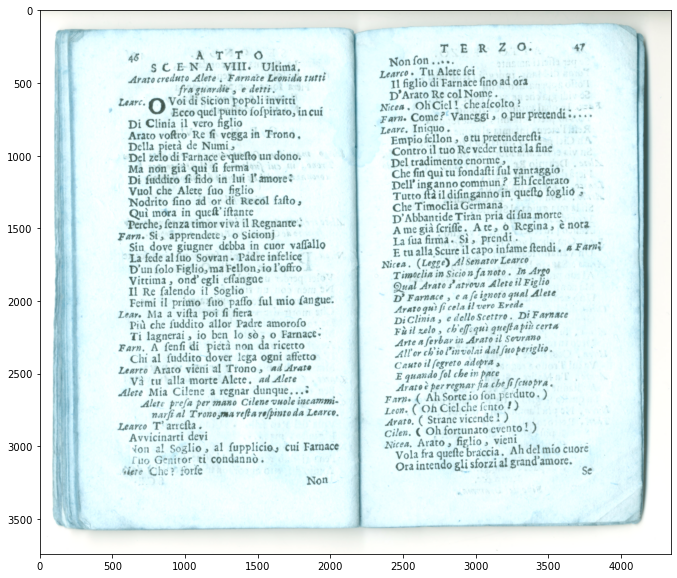

Percentage of correct translated words: 70.48% for the processed text
Document id: 31679
Percentage of correct translated words: 53.53% for the original text


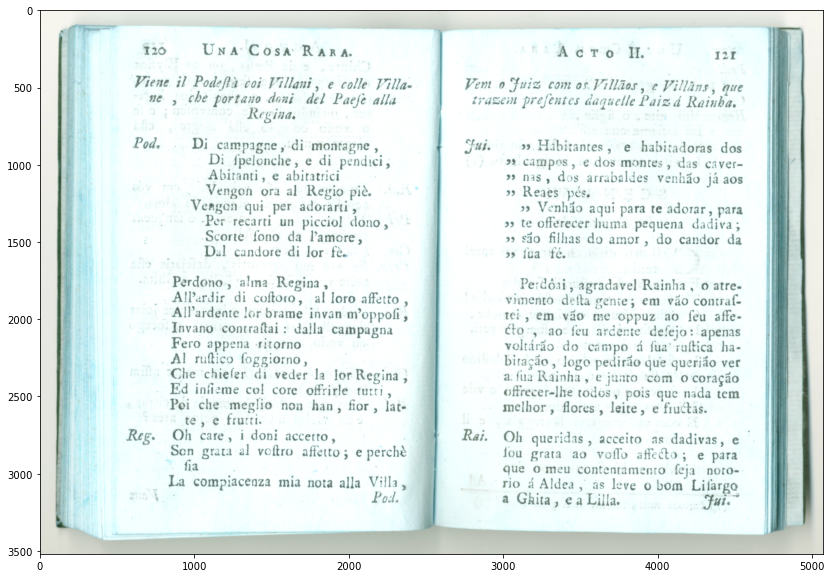

Percentage of correct translated words: 54.03% for the processed text
Document id: 9519
Percentage of correct translated words: 68.16% for the original text


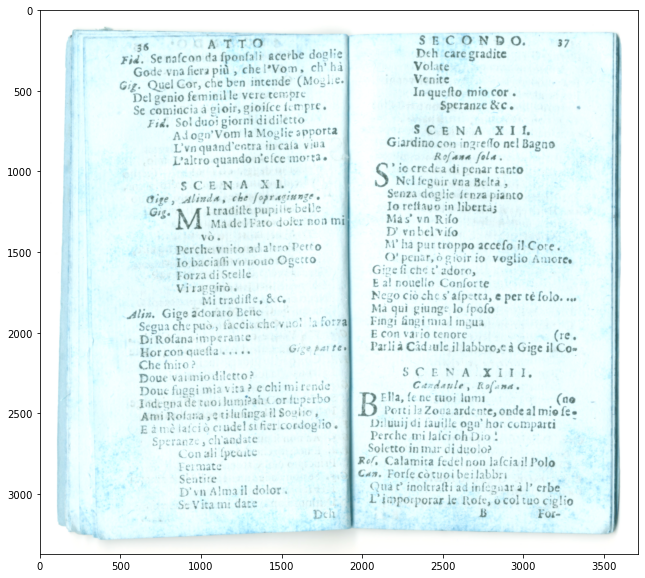

Percentage of correct translated words: 67.71% for the processed text
Document id: 24675
Percentage of correct translated words: 69.98% for the original text


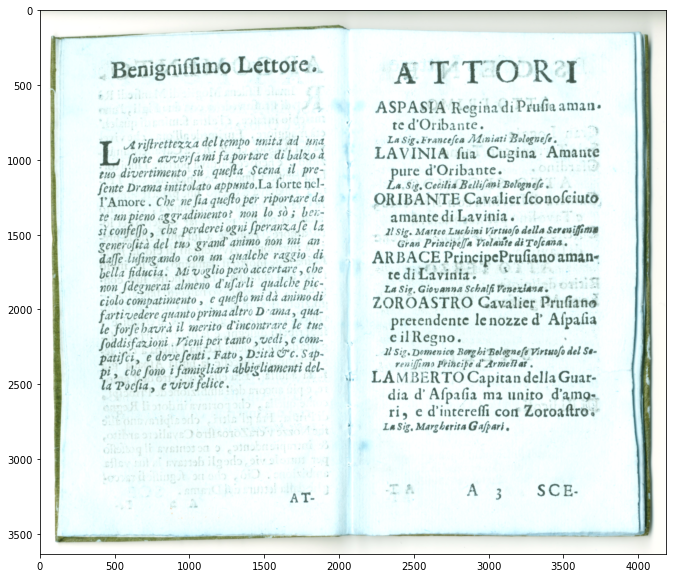

Percentage of correct translated words: 73.53% for the processed text


In [13]:
# Start at 18, end at 36042
FIRST_IMAGE = 18
LAST_IMAGE = 36042

libretto_dict = dict()

for i in np.random.randint(FIRST_IMAGE,LAST_IMAGE, size=5):
    url_page = "http://dl.cini.it/items/show/" + str(i)
    title, url_image = retrieve_url_and_title(url_page)
    urllib.request.urlretrieve(url_image, "temporary.jpg")
    
    # If we already started one libretti, we append the new page text to the old one
    # Otherwise we create a new entry
    #if title in libretto_dict:
    #    libretto_dict[title] = libretto_dict[title] + " " + text
    #else:
    #    libretto_dict[title] = text
    
    # Original steps
    print("Document id:", i)
    # Step 1: detect text
    text, bounds = detect_text("temporary.jpg") 
    # Step 2: Translate
    deepl_translation = translate(text)
    # Step 3: Check correct words
    check_translation(deepl_translation, 'original')
    
    # Process steps
    # Step 0:
    pre_processing()
    # Step 1: detect text
    text, bounds = detect_text("processed.jpeg") 
    # Step 2: translate
    deepl_translation = translate(text)
    # Step 3: Check correct words
    check_translation(deepl_translation, 'processed')

### Remarks

We've stopped working on the pre-processing and reallignment of the texts for the following reasons:
* the parameters concerning the pre-processing and removal of the noisy background of the images depend on too many parameters, that vary extremely from one libretti to another
* the methods to align words extracted from the image is way too complex. Coordinates are very precise, and thus one line is not represented by a single y-value but by many in a small range because of the way the OCR detected the boxes. And because one has to take into account the fact that the scan of the images are crooked, which influences the coordinates of the box surrounding the words, it is already really complex to process a single libretti having these problems. 